In [125]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import openpyxl
from openpyxl import load_workbook
import os
import geopandas as gp
import yaml
import math
import h5py

from scipy.spatial import ConvexHull
from scipy.interpolate import griddata
from shapely.geometry import Point, Polygon

from pykrige.ok import OrdinaryKriging
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from pyproj import Proj
from scipy.io import savemat
from scipy.ndimage import gaussian_filter

In [126]:
import sys
sys.path.append(r'../tools_F-J/')
from toollib_standard import plotlib

In [127]:
flag_project = 1 # 0--regular; 1--repartrition
flag_smooth = 1

In [128]:
if flag_project == 0:
    file_project = 'a-project.yml'
elif flag_project == 1:
    file_project = 'a-project_repar.yml'
elif flag_project == 2:
    file_project = 'a-project_voro.yml'
    
with open(file_project, 'r', encoding='utf-8') as f:
    proj = yaml.load(f.read(), Loader=yaml.FullLoader)
name_project = proj['name']

#name_project = 'project/output_FJSJ_16-01/'               
#name_project = 'project_repartrition/repartrition_01-03/'               
#name_project = 'project_voronoi/voronoi_01-03/'         

In [129]:
with open('0_config.yml', 'r', encoding='utf-8') as f:
    dir_config = yaml.load(f.read(), Loader=yaml.FullLoader)
dir_project_workspace = dir_config['dir_project_workspace']
dir_CC_workspace = dir_config['dir_CC_workspace']
print('dir_CC_workspace: ', dir_CC_workspace)
print('dir_project_workspace: ', dir_project_workspace)
dir_project = os.path.join(dir_project_workspace, name_project)
print('dir_project: ', dir_project)

dir_CC_workspace:  ./
dir_project_workspace:  ./
dir_project:  ./project_repartition_v4.0/output_repar_v9.5_02--10-16Hz/


In [130]:
filename = dir_project+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project+'Basic_info.npy'
info_basic_bi = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

In [131]:
dir_model_fund = dir_project + info_basic['rdir_model_fund']
dir_model = dir_project + info_basic['rdir_model']
dir_disp = dir_project + info_basic['rdir_disp_model']
dir_inv = dir_project + info_basic['rdir_inv_BFGS']
dir_image = dir_project + info_basic['rdir_image']+'Vs_compare/'
if not os.path.exists(dir_image):
    os.makedirs(dir_image)
dir_partition = dir_project + info_basic['rdir_partition']
key_subworks = info_basic['key_subworks']
M = len(key_subworks)
key_subworks

['264--12-10',
 '536--49-16',
 '63--47-04',
 '493--38-15',
 '338--46-11',
 '249--40-09',
 '210--45-08',
 '41--10-04',
 '540--07-17',
 '184--18-08',
 '411--30-13',
 '201--36-08',
 '406--25-13',
 '324--32-11',
 '15--23-03',
 '572--09-18',
 '307--08-11',
 '476--08-15',
 '55--31-04',
 '113--25-06',
 '175--51-07',
 '169--45-07',
 '385--49-12',
 '9--16-03',
 '218--53-08',
 '512--09-16',
 '183--17-08',
 '272--21-10',
 '545--13-17',
 '535--48-16',
 '56--32-04',
 '337--45-11',
 '89--40-05',
 '489--34-15',
 '575--12-18',
 '277--26-10',
 '556--35-17',
 '65--49-04',
 '10--18-03',
 '593--50-18',
 '199--34-08',
 '367--31-12',
 '390--54-12',
 '282--31-10',
 '204--39-08',
 '461--41-14',
 '423--42-13',
 '157--32-07',
 '392--09-13',
 '332--40-11',
 '442--18-14',
 '357--20-12',
 '353--15-12',
 '372--36-12',
 '233--24-09',
 '248--39-09',
 '531--44-16',
 '284--33-10',
 '191--25-08',
 '510--07-16',
 '568--53-17',
 '217--52-08',
 '36--52-03',
 '44--17-04',
 '521--34-16',
 '105--14-06',
 '437--08-14',
 '93--4

In [132]:
dir_file = 'ModelValidCode/ModelValidCode/parameter_prepare/'

In [133]:
def GetStationPairs(nsta):
    StationPair = []
    for ii in range(nsta):
        for jj in range(ii+1,nsta):
            StationPair.append(ii)
            StationPair.append(jj)
    StationPair = np.array(StationPair,dtype=np.int32)
    return StationPair

In [134]:
stalistname_all = info_basic['stalistname_all']
stainfo = pd.read_excel(stalistname_all)
nsta_all = len(stainfo.iloc[:,0])
StationPairs_all = GetStationPairs(nsta_all)
nPairs_all = int(len(StationPairs_all)/2)
stalist_all = stainfo['Station'].tolist() 
lat_stations_all =  stainfo['latitude'].tolist() 
lon_stations_all =  stainfo['longitude'].tolist() 
elevation_stations_all = stainfo['elevation'].tolist()

In [135]:
stations_partition = {}
lat_stations_partition = {}
lon_stations_partition = {}
lat_centroid_partition = []
lon_centroid_partition = []
num_stations = []
for key in key_subworks:
    filepath = dir_partition + str(key) + '.txt'
    stations_this, lat_stations_this, lon_stations_this = np.loadtxt(filepath, dtype='str' , unpack=True)
    stations_partition[key] = stations_this
    lat_stations_partition[key] = lat_stations_this.astype(float)
    lon_stations_partition[key] = lon_stations_this.astype(float)
    num_stations.append(len(stations_this))
    lat_centroid_partition.append(np.mean(lat_stations_this.astype(float)))
    lon_centroid_partition.append(np.mean(lon_stations_this.astype(float)))

In [136]:
faults = np.load('clark_faults.npy', allow_pickle='TRUE').item()

In [137]:
#points = np.column_stack((lon_stations_all, lat_stations_all))
points = np.column_stack((lon_centroid_partition, lat_centroid_partition))
hull = ConvexHull(points)
polygon = Polygon(points[hull.vertices])
index_sta = []
lon_stations_in = []
lat_stations_in = []
stalist_in = []
elevation_stations_in = []
for i in range(len(lon_stations_all)):
    if polygon.contains(Point(lon_stations_all[i], lat_stations_all[i])):
        index_sta.append(i)
        stalist_in.append(stalist_all[i])
        lon_stations_in.append(lon_stations_all[i])
        lat_stations_in.append(lat_stations_all[i])
        elevation_stations_in.append(elevation_stations_all[i])

In [138]:
def compute_affine_transform(original_points, target_points):
    A_matrix = np.array([[original_points[0][0], original_points[0][1], 1, 0, 0, 0],
                         [0, 0, 0, original_points[0][0], original_points[0][1], 1],
                         [original_points[1][0], original_points[1][1], 1, 0, 0, 0],
                         [0, 0, 0, original_points[1][0], original_points[1][1], 1],
                         [original_points[2][0], original_points[2][1], 1, 0, 0, 0],
                         [0, 0, 0, original_points[2][0], original_points[2][1], 1]])

    A1_B1_C1 = np.array([target_points[0][0], target_points[0][1], target_points[1][0], target_points[1][1], target_points[2][0], target_points[2][1]])

    coefficients = np.linalg.solve(A_matrix, A1_B1_C1)

    affine_matrix = np.array([[coefficients[0], coefficients[1], coefficients[2]],
                               [coefficients[3], coefficients[4], coefficients[5]],
                               [0, 0, 1]])

    return affine_matrix

In [139]:
# Affine transformation
lon_stations_all_new = []
lat_stations_all_new = []
for sta in stalist_all:
    if int(sta[1:3]) <= 60:
        lon_stations_all_new.append(lon_stations_all[stalist_all.index(sta)])
        lat_stations_all_new.append(lat_stations_all[stalist_all.index(sta)])
refs = ['R0101','R6001','R6020']
lon_refs = [lon_stations_all[stalist_all.index(ref)] for ref in refs]
lat_refs = [lat_stations_all[stalist_all.index(ref)] for ref in refs]
loc_refs = np.column_stack([lon_refs,lat_refs])
loc_refs_new = np.array([[0,0],[600,0],[600,600]])

affine_matrix = compute_affine_transform(loc_refs, loc_refs_new)

In [140]:
# all stations
x_stations_all = []
y_stations_all = []
for i in range(len(lon_stations_all)):
    loc_sta = np.array([lon_stations_all[i],lat_stations_all[i],1])
    loc_sta_new = np.dot(affine_matrix,loc_sta)
    x_stations_all.append(loc_sta_new[0])
    y_stations_all.append(loc_sta_new[1])
# new stations
x_stations_all_new = []
y_stations_all_new = []
for i in range(len(lon_stations_all_new)):
    loc_sta = np.array([lon_stations_all_new[i],lat_stations_all_new[i],1])
    loc_sta_new = np.dot(affine_matrix,loc_sta)
    x_stations_all_new.append(loc_sta_new[0])
    y_stations_all_new.append(loc_sta_new[1])
# in stations
x_stations_in = []
y_stations_in = []
for i in range(len(lon_stations_in)):
    loc_sta = np.array([lon_stations_in[i],lat_stations_in[i],1])
    loc_sta_new = np.dot(affine_matrix,loc_sta)
    x_stations_in.append(loc_sta_new[0])
    y_stations_in.append(loc_sta_new[1])
# faults
x_faults = {}
y_faults = {}
faults_trans = {}   
for i in range(len(faults)):
    x_faults['clark'+str(i+1)] = []
    y_faults['clark'+str(i+1)] = []
    faults_trans['clark'+str(i+1)] = {}
    for j in range(len(faults['clark'+str(i+1)]['lon'])):
        loc_fault = np.array([faults['clark'+str(i+1)]['lon'][j],faults['clark'+str(i+1)]['lat'][j],1])
        loc_fault_new = np.dot(affine_matrix,loc_fault)
        x_faults['clark'+str(i+1)].append(loc_fault_new[0])
        y_faults['clark'+str(i+1)].append(loc_fault_new[1])
        faults_trans['clark'+str(i+1)]['x'] = x_faults['clark'+str(i+1)]
        faults_trans['clark'+str(i+1)]['y'] = y_faults['clark'+str(i+1)]
# partitions
x_centroid_partition = []
y_centroid_partition = []
for i in range(len(lon_centroid_partition)):
    loc_centroid = np.array([lon_centroid_partition[i],lat_centroid_partition[i],1])
    loc_centroid_new = np.dot(affine_matrix,loc_centroid)
    x_centroid_partition.append(loc_centroid_new[0])
    y_centroid_partition.append(loc_centroid_new[1])

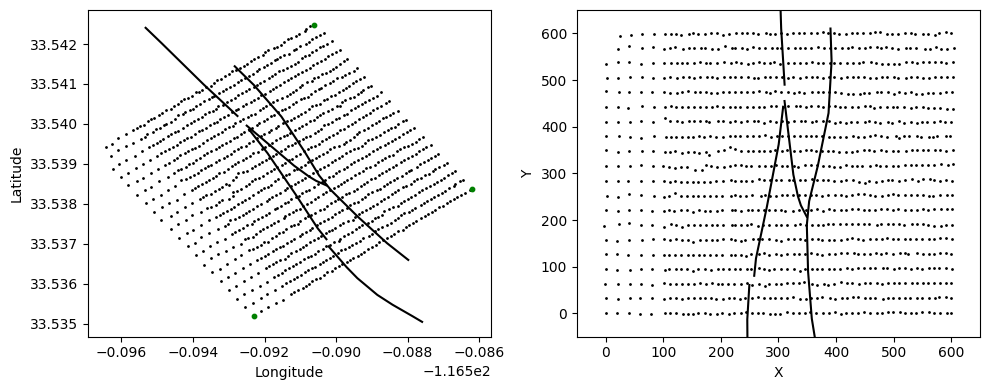

In [141]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121)
ax.scatter(lon_stations_all_new, lat_stations_all_new, c='k', label='Original',s = 1)
for ref in refs:
    ax.scatter(lon_stations_all[stalist_all.index(ref)], lat_stations_all[stalist_all.index(ref)], c='g', label='Original',s = 10)
for i in range(len(faults)):
    ax.plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'k')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax = fig.add_subplot(122)
ax.scatter(x_stations_all_new, y_stations_all_new, c='k', label='Original',s = 1)
for i in range(len(faults)):
    ax.plot(x_faults['clark'+str(i+1)], y_faults['clark'+str(i+1)], 'k')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xlim(-50,650)
ax.set_ylim(-50,650)
plt.tight_layout()

In [142]:
def cartesian_to_geographic_2d(x, y):
    # 定义一个适当的投影，根据你的数据选择合适的投影方式
    # 这里假设使用 WGS 84 椭球体投影
    proj = Proj(proj='utm', zone=10, ellps='WGS84')
    
    # 将笛卡尔坐标系转换为经纬度,单位为米
    lon, lat = proj(x, y, inverse=True)
    
    return lon, lat

In [143]:
# save station in
lon_stations_in_new = np.zeros_like(x_stations_in)
lat_stations_in_new = np.zeros_like(y_stations_in)
for i in range(len(x_stations_in)):
    lon, lat = cartesian_to_geographic_2d(x_stations_in[i], y_stations_in[i])
    lon_stations_in_new[i] = lon
    lat_stations_in_new[i] = lat

In [144]:
# obs parameters
dir_CC = dir_CC_workspace + 'CC/CC_150_prewhiten/'
isline = False
LenFD = 3
putinrou = [dir_CC + 'CFs_modelvalidate/'+ 'gather_all_modelvalidate.h5']
syn_stalist = dir_file + 'stations_in.txt'
sele_stalist = dir_file + 'stations_in.txt'
srclist = dir_file + 'stations_virsrc.txt'
#=============================read observed Ccfs====================================
CC_file = []
CC_prof = []
for i in range(len(putinrou)):
  CC_prof.append(pd.read_hdf(putinrou[i], 'cc_prof'))
  with h5py.File(putinrou[i], mode = "r") as file_rou:
      CC_file.append(np.array(file_rou[list(file_rou.keys())[0]]))
CC_array = CC_file[0]
CC_table = CC_prof[0]
f_prof = pd.read_hdf(putinrou[0], 'freq')
freq = np.array(f_prof[:])[:,0]

In [145]:
f_list = [5,10,15]
phase = {}
for f in f_list:
    phase[f] = []
for key in key_subworks:
    disp = np.loadtxt(dir_disp + 'disp_model_'+key+'.txt')
    disp = disp[disp[:,2] == 0]
    for f in f_list:
        phase[f].append(disp[disp[:,0]==f][0][1])

In [514]:
name_src = 'R3505'

R3505


[]

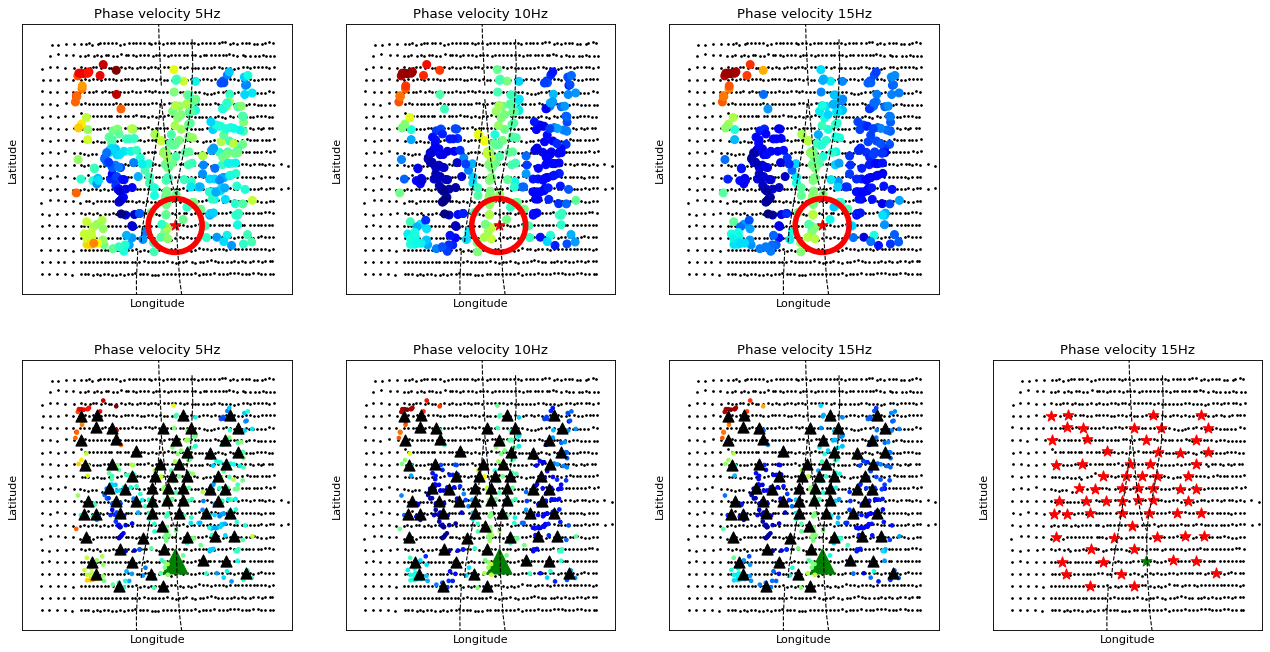

In [515]:
flag_maxd = 0.07
index_sta = stalist_in.index(name_src)
print(name_src)
x_src_this = x_stations_in[index_sta]
y_src_this = y_stations_in[index_sta]

fig = plt.figure(figsize = (20, 10), dpi = 80)
for i in range(len(phase)):
    ax_phase = fig.add_subplot(2,4,i+1)
    ax_phase.scatter(x_stations_all,y_stations_all,marker='o',c = 'k',s = 2)
    for j in range(len(faults)):
        ax_phase.plot(x_faults['clark'+str(j+1)],y_faults['clark'+str(j+1)],'k--',lw=1)
    ax_phase.scatter(x_centroid_partition,y_centroid_partition,marker='o',c  = phase[f_list[i]],s = 50, cmap = 'jet')
    ax_phase.scatter(x_src_this,y_src_this,marker='*',color='r',s=100)
    circle = plt.Circle((x_src_this,y_src_this),flag_maxd*1e3,fill=False,color = 'r',lw = 5)
    ax_phase.add_artist(circle)
    ax_phase.set_title('Phase velocity '+str(f_list[i])+'Hz')
    ax_phase.set_xlabel('Longitude')
    ax_phase.set_ylabel('Latitude')
    ax_phase.set_xlim([-50,650])
    ax_phase.set_ylim([-50,650])
    ax_phase.set_aspect('equal')
    ax_phase.set_xticks([])
    ax_phase.set_yticks([])

filename = dir_project + 'modelValidate_src.txt'
srcs = np.loadtxt(filename, dtype='str', unpack=True)
for i in range(len(phase)):
    ax_phase = fig.add_subplot(2,4,i+5)
    ax_phase.scatter(x_stations_all,y_stations_all,marker='o',c = 'k',s = 2)
    for j in range(len(faults)):
        ax_phase.plot(x_faults['clark'+str(j+1)],y_faults['clark'+str(j+1)],'k--',lw=1)
    ax_phase.scatter(x_src_this,y_src_this,marker='^',color='g',s=500)
    ax_phase.scatter(x_centroid_partition,y_centroid_partition,marker='o',c  = phase[f_list[i]],s = 10, cmap = 'jet')
    #circle = plt.Circle((x_src_this,y_src_this),flag_maxd*1e3,fill=False,color = 'r',lw = 5)
    #ax_phase.add_artist(circle)
    for j in range(len(srcs)):
        index_sta = stalist_in.index(srcs[j])
        x_src = x_stations_in[index_sta]
        y_src = y_stations_in[index_sta]
        ax_phase.scatter(x_src,y_src,marker='^',color='k',s=100)
        #circle = plt.Circle((x_src,y_src),flag_maxd*1e3,fill=False,color = 'r',lw = 5)
        #ax_phase.add_artist(circle)
    ax_phase.set_title('Phase velocity '+str(f_list[i])+'Hz')
    ax_phase.set_xlabel('Longitude')
    ax_phase.set_ylabel('Latitude')
    ax_phase.set_xlim([-50,650])
    ax_phase.set_ylim([-50,650])
    ax_phase.set_aspect('equal')
    ax_phase.set_xticks([])
    ax_phase.set_yticks([])
ax_phase = fig.add_subplot(2,4,8)
ax_phase.scatter(x_stations_all,y_stations_all,marker='o',c = 'k',s = 2)
for j in range(len(faults)):
    ax_phase.plot(x_faults['clark'+str(j+1)],y_faults['clark'+str(j+1)],'k--',lw=1)
for j in range(len(srcs)):
    index_sta = stalist_in.index(srcs[j])
    x_src = x_stations_in[index_sta]
    y_src = y_stations_in[index_sta]
    ax_phase.scatter(x_src,y_src,marker='*',color='r',s=100)
    #circle = plt.Circle((x_src,y_src),flag_maxd*1e3,fill=False,color = 'r',lw = 5)
    #ax_phase.add_artist(circle)
#ax_phase.scatter(x_centroid_partition,y_centroid_partition,marker='o',c  = phase[f_list[i]],s = 50, cmap = 'jet')
ax_phase.scatter(x_src_this,y_src_this,marker='*',color='g',s=100)
circle = plt.Circle((x_src_this,y_src_this),flag_maxd*1e3,fill=False,color = 'r',lw = 5)
ax_phase.set_title('Phase velocity '+str(f_list[i])+'Hz')
ax_phase.set_xlabel('Longitude')
ax_phase.set_ylabel('Latitude')
ax_phase.set_xlim([-50,650])
ax_phase.set_ylim([-50,650])
ax_phase.set_aspect('equal')
ax_phase.set_xticks([])
ax_phase.set_yticks([])
